In [5]:
import pandas as pd

# Replace 'path_to_your_dataset/your_dataset.csv' with the actual file path
file_path = 'ExplainEDU_data.csv'

# Load the dataset
students = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataset
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [1]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)


In [6]:
# Import important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing and EDA
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

## Data Cleaning

In [7]:
# Correct a column name that has a typo and replace single quotes with underscores
students.rename(columns = {"Nacionality": "Nationality",
                           "Mother's qualification": "Mother_qualification",
                           "Father's qualification": "Father_qualification",
                           "Mother's occupation": "Mother_occupation",
                           "Father's occupation": "Father_occupation",
                           "Age at enrollment": "Age"}, inplace = True)

# Replace white space in the column names with underscore
students.columns = students.columns.str.replace(' ', '_')

# Remove the parenthesis
students.columns = students.columns.str.replace('(', '', regex=True)
students.columns = students.columns.str.replace(')', '', regex=True)

In [8]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Application_order', 'Course',
      'Daytime/evening_attendance\t', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International', 'Target']

students[col] = students[col].astype('category')

## Exploratory Data Analysis

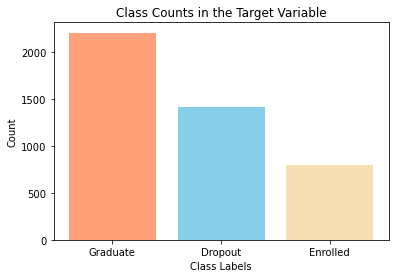

In [9]:
# Count the occurrences of each class in the target variable
labels = students['Target'].value_counts().index
values = students['Target'].value_counts().values

# Create a bar chart for class counts
plt.bar(labels, values, color=['lightsalmon', 'skyblue', 'wheat'])
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Counts in the Target Variable')
plt.show()


In [10]:
# Encode the labels as ordinal data (0 - 'Dropout', 1 - 'Enrolled', and 2 - 'Graduate')
students['Target_encoded'] = OrdinalEncoder(categories = [['Dropout', 'Enrolled', 'Graduate']]).fit_transform(students[['Target']])

# Drop 'Target' variable
students.drop('Target', axis = 1, inplace = True)

In [11]:
# list of categorical features
cats = ['Marital_status', 'Application_mode', 'Application_order',
        'Course','Daytime/evening_attendance\t', 'Previous_qualification',
        'Nationality','Mother_qualification', 'Father_qualification',
        'Mother_occupation', 'Father_occupation', 'Displaced',
        'Educational_special_needs', 'Debtor','Tuition_fees_up_to_date',
        'Gender', 'Scholarship_holder','International']

# Get the p-values from Chi-Square indenpendence tests
p_value = []

for col in cats:
    crosstable = pd.crosstab(index = students[col],
                             columns = students['Target_encoded'])
    p = chi2_contingency(crosstable)[1]
    p_value.append(p)

chi2_result = pd.DataFrame({
    'Variable': cats,
    'P_value': [round(ele, 5) for ele in p_value]
})

chi2_result = chi2_result.sort_values('P_value')

chi2_result

,Variable,P_value
0,Marital_status,0.00000
15,Gender,0.00000
14,Tuition_fees_up_to_date,0.00000
13,Debtor,0.00000
11,Displaced,0.00000
10,Father_occupation,0.00000
9,Mother_occupation,0.00000
16,Scholarship_holder,0.00000
8,Father_qualification,0.00000
5,Previous_qualification,0.00000


In [12]:
stud_selected = students.drop(['Nationality', 'International', 'Educational_special_needs'],
                              axis = 1)

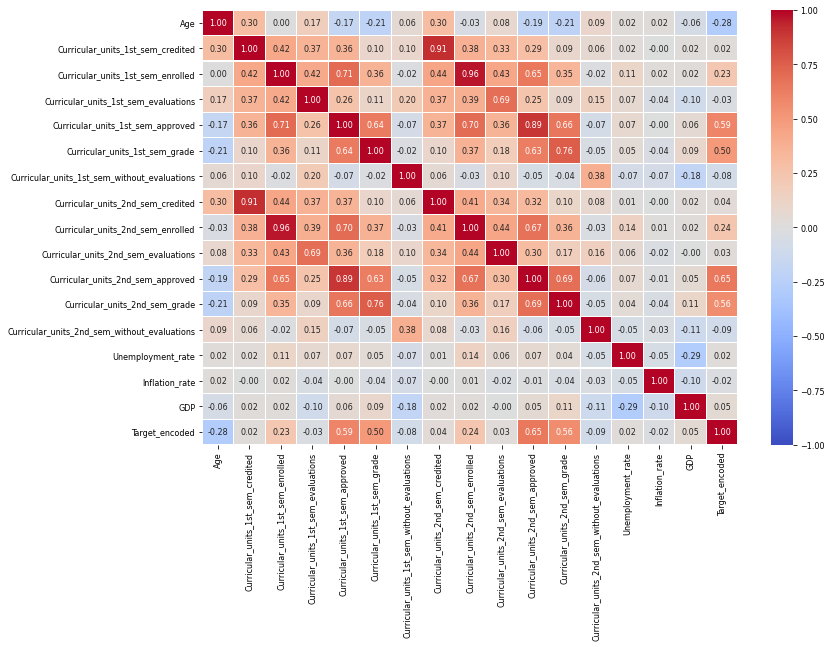

In [13]:
# Numeric features
num_features = students[['Age',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved',
       'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved',
       'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations',
       'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target_encoded']]

# Heatmap of correlation matrix
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 8})
hm = sns.heatmap(num_features.corr(method = 'spearman'),
                 cmap = 'coolwarm', annot = True, fmt = '.2f',
                 linewidths = .2, vmin = -1, vmax = 1, center = 0)

In [14]:
# Averaging academic performance data across two semesters
stud_selected['avg_credited'] = stud_selected[['Curricular_units_1st_sem_credited',
                                'Curricular_units_2nd_sem_credited']].mean(axis = 1)
stud_selected['avg_enrolled'] = stud_selected[['Curricular_units_1st_sem_enrolled',
                                'Curricular_units_2nd_sem_enrolled']].mean(axis = 1)
stud_selected['avg_evaluations'] = stud_selected[['Curricular_units_1st_sem_evaluations',
                                   'Curricular_units_2nd_sem_evaluations']].mean(axis = 1)
stud_selected['avg_approved'] = stud_selected[['Curricular_units_1st_sem_approved',
                                'Curricular_units_2nd_sem_approved']].mean(axis = 1)
stud_selected['avg_grade'] = stud_selected[['Curricular_units_1st_sem_grade',
                             'Curricular_units_2nd_sem_grade']].mean(axis = 1)
stud_selected['avg_without_evaluations'] = stud_selected[['Curricular_units_1st_sem_without_evaluations',
                                           'Curricular_units_2nd_sem_without_evaluations']].mean(axis = 1)

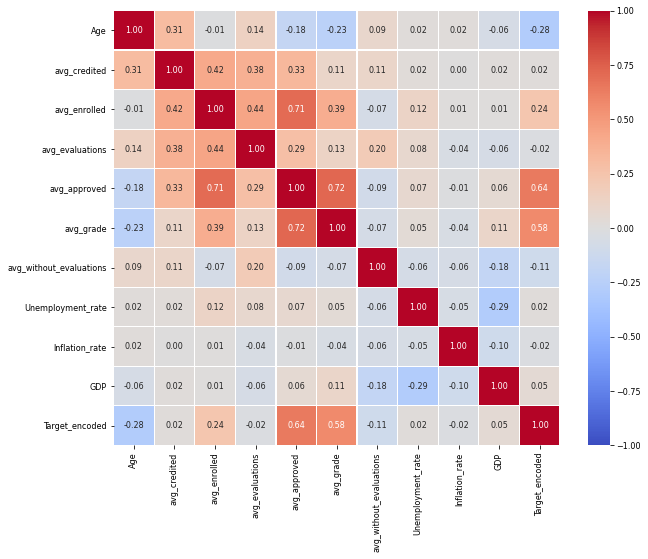

In [15]:
# plot the heat map of correlation matrix again
num_features = stud_selected[['Age', 'avg_credited', 'avg_enrolled',
                              'avg_evaluations', 'avg_approved',
                              'avg_grade', 'avg_without_evaluations',
                              'Unemployment_rate', 'Inflation_rate',
                              'GDP', 'Target_encoded']]

plt.figure(figsize = (10, 8))
plt.rcParams.update({'font.size': 8})
sns.heatmap(num_features.corr(method = 'spearman'), vmin = -1, vmax = 1, center = 0,
            cmap = 'coolwarm', fmt = '.2f', linewidths = .2, annot = True);

In [16]:
# Drop unselected features along with the features that have been aggregated into new ones
stud_selected = stud_selected.drop(columns = ['Unemployment_rate', 'Inflation_rate',
                                              'avg_credited', 'avg_evaluations',
                                              'Curricular_units_1st_sem_credited',
                                              'Curricular_units_1st_sem_enrolled',
                                              'Curricular_units_1st_sem_evaluations',
                                              'Curricular_units_1st_sem_approved',
                                              'Curricular_units_1st_sem_grade',
                                              'Curricular_units_1st_sem_without_evaluations',
                                              'Curricular_units_2nd_sem_credited',
                                              'Curricular_units_2nd_sem_enrolled',
                                              'Curricular_units_2nd_sem_evaluations',
                                              'Curricular_units_2nd_sem_approved',
                                              'Curricular_units_2nd_sem_grade',
                                              'Curricular_units_2nd_sem_without_evaluations'])

In [17]:
# Show basic information about the dataset
print("Basic Information about the dataset:")
print(stud_selected.info())

# Show counts of unique values for each feature
print("\nCounts of unique values for each feature:")
unique_counts = stud_selected.nunique()
print(unique_counts)

# Optionally, show value counts for categorical features
print("\nValue counts for each categorical feature:")
for col in stud_selected.select_dtypes(include=['object']).columns:
    print(f"\nValue counts for {col}:")
    print(stud_selected[col].value_counts())

Basic Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Marital_status                4424 non-null   category
 1   Application_mode              4424 non-null   category
 2   Application_order             4424 non-null   category
 3   Course                        4424 non-null   category
 4   Daytime/evening_attendance	   4424 non-null   category
 5   Previous_qualification        4424 non-null   category
 6   Previous_qualification_grade  4424 non-null   float64 
 7   Mother_qualification          4424 non-null   category
 8   Father_qualification          4424 non-null   category
 9   Mother_occupation             4424 non-null   category
 10  Father_occupation             4424 non-null   category
 11  Admission_grade               4424 non-null   float64 
 12  Displaced  

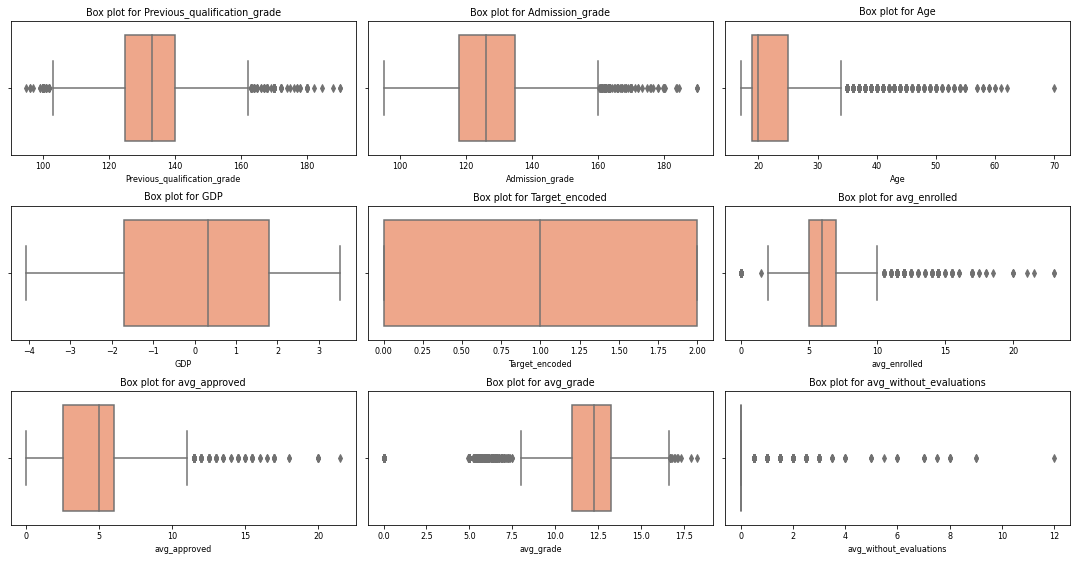

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'stud_selected' is your DataFrame
def show_outliers(data):
    # Select numerical features
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns

    # Create box plots for numerical features to visualize outliers
    plt.figure(figsize=(15, 10))

    for i, col in enumerate(numeric_features):
        plt.subplot(len(numeric_features) // 3 + 1, 3, i + 1)  # Adjust grid size
        sns.boxplot(x=data[col], color='lightsalmon')
        plt.title(f'Box plot for {col}')

    plt.tight_layout()
    plt.show()

# Call the function to display outliers and counts for numerical features
show_outliers(stud_selected)


In [19]:
def remove_outliers_iqr(data, iqr_multiplier=3.5):  # Updated to 2.0
    # Select only numerical features
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns

    # Create a copy of the dataset
    df = data.copy()

    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds with the updated multiplier
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        print(f"{feature}: Lower bound = {lower_bound}, Upper bound = {upper_bound}")

        # Remove outliers by filtering within bounds
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    return df

# Now remove outliers using a more aggressive approach
stud_selected_cleaned = remove_outliers_iqr(stud_selected, iqr_multiplier=3.5)

# Show the shape before removing more outliers
print(f"Raw Dataset shape: {stud_selected.shape}")

# Show the shape after removing more outliers
print(f"Cleaned dataset shape with 2.0 IQR multiplier: {stud_selected_cleaned.shape}")


Previous_qualification_grade: Lower bound = 72.5, Upper bound = 192.5
Admission_grade: Lower bound = 58.749999999999986, Upper bound = 193.95000000000005
Age: Lower bound = -2.0, Upper bound = 46.0
GDP: Lower bound = -13.915, Upper bound = 14.004999999999999
Target_encoded: Lower bound = -7.0, Upper bound = 9.0
avg_enrolled: Lower bound = -2.0, Upper bound = 14.0
avg_approved: Lower bound = -9.75, Upper bound = 18.25
avg_grade: Lower bound = 3.0331250000000027, Upper bound = 21.243124999999996
avg_without_evaluations: Lower bound = 0.0, Upper bound = 0.0
Raw Dataset shape: (4424, 24)
Cleaned dataset shape with 2.0 IQR multiplier: (3245, 24)


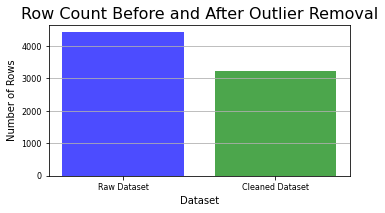

In [20]:
# Count the number of rows in both datasets
raw_row_count = len(stud_selected)  # Total rows in the raw dataset
cleaned_row_count = len(stud_selected_cleaned)  # Total rows in the cleaned dataset

# Prepare data for plotting
counts = [raw_row_count, cleaned_row_count]
labels = ['Raw Dataset', 'Cleaned Dataset']

# Plotting
plt.figure(figsize=(5, 3))
plt.bar(labels, counts, color=['blue', 'green'], alpha=0.7)

# Adding titles and labels
plt.title('Row Count Before and After Outlier Removal', fontsize=16)
plt.xlabel('Dataset', fontsize=10)
plt.ylabel('Number of Rows', fontsize=10)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

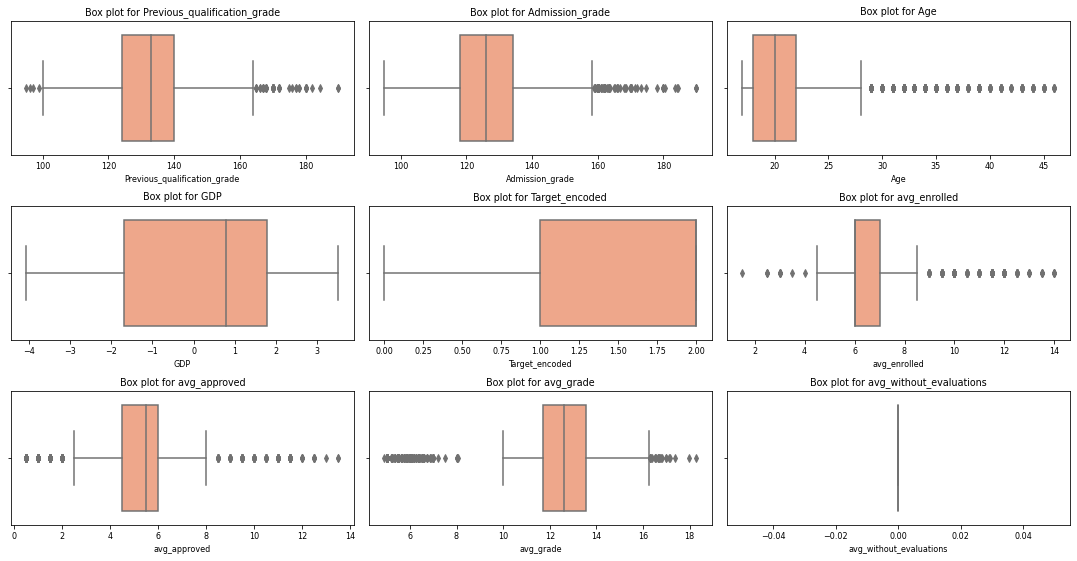

In [21]:
# Plot the boxplots for the cleaned data
def show_boxplots(data):
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_features):
        plt.subplot(len(numeric_features) // 3 + 1, 3, i + 1)
        sns.boxplot(x=data[col], color='lightsalmon')
        plt.title(f'Box plot for {col}')
    plt.tight_layout()
    plt.show()

# Call the function to visualize the cleaned data
show_boxplots(stud_selected_cleaned)

In [22]:
# Split the data into training and test set
train, test = train_test_split(stud_selected_cleaned, test_size=0.2,
                               stratify=stud_selected_cleaned['Target_encoded'], random_state=0)

# Extract features and labels
train_features = train.drop('Target_encoded', axis=1)
train_labels = train['Target_encoded']
test_features = test.drop('Target_encoded', axis=1)
test_labels = test['Target_encoded']

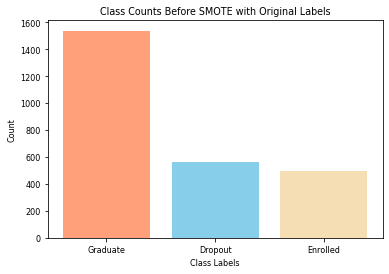

In [23]:
# Mapping of encoded values back to original labels
label_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}

# Show class count before SMOTE
class_count_before_smote = train_labels.value_counts()

# Plot the class counts as a histogram (bar chart) using original class labels
plt.bar(class_count_before_smote.index.map(label_mapping), class_count_before_smote.values, color=['lightsalmon', 'skyblue', 'wheat'])
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Counts Before SMOTE with Original Labels')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

In [21]:
!pip install imbalanced-learn

In [24]:
# Apply SMOTE to the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
train_features, train_labels = smote.fit_resample(train_features, train_labels)

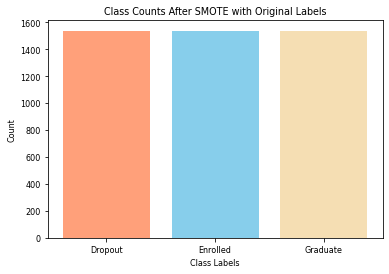

In [23]:
# Show the class distribution after SMOTE
label_counts = train_labels.value_counts()

# Mapping of encoded values back to original labels
label_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}

# Plot the class counts as a histogram (bar chart) using original class labels
plt.bar(label_counts.index.map(label_mapping), label_counts.values, color=['lightsalmon', 'skyblue', 'wheat'])
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Counts After SMOTE with Original Labels')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

## Model Training : For 3 class - Graduate, Enrolled, Dropout

In [29]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.impute import SimpleImputer
import pandas as pd
imputer = SimpleImputer(strategy='mean')
train_features = pd.DataFrame(imputer.fit_transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(imputer.transform(test_features), columns=test_features.columns)

# Train random forest on the training set, set 'class_weight' as 'balanced' to adjust weights of our imbalanced data.
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_base.fit(train_features, train_labels)

# Make predictions
y_pred = rf_base.predict(test_features)
y_prob = rf_base.predict_proba(test_features)

# Calculate normal accuracy, F1 score, and AUC score
rf_base_accuracy = round(accuracy_score(test_labels, y_pred), 3)
rf_base_f1score = round(f1_score(test_labels, y_pred, average='macro'), 3)
rf_base_auc = round(roc_auc_score(test_labels, y_prob, average='macro', multi_class='ovr'), 3)

# Print performance metrics
print('Random Forest Baseline Performance:')
print('Accuracy:', rf_base_accuracy)
print('F1 Score:', rf_base_f1score)
print('AUC score:', rf_base_auc)

Random Forest Baseline Performance:
Accuracy: 0.761
F1 Score: 0.663
AUC score: 0.871


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Create the parameter grid
parm = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 5],
    'max_samples': [0.5, 0.75, 1]
}

# Tune the hyperparameters of the Random Forest
rsv_rf = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                              random_state=42),
                            param_distributions=parm, scoring='accuracy',  # Use normal accuracy
                            n_iter=30, n_jobs=1, random_state=0)

rsv_rf.fit(train_features, train_labels)

# Get the best estimator
tuned_rf = rsv_rf.best_estimator_

# Check the model performance
y_pred = tuned_rf.predict(test_features)
y_prob = tuned_rf.predict_proba(test_features)

# Calculate normal accuracy, F1 score, and AUC score
tuned_rf_accuracy = round(accuracy_score(test_labels, y_pred), 3)  # Normal accuracy
tuned_rf_f1score = round(f1_score(test_labels, y_pred, average='macro'), 3)
tuned_rf_auc = round(roc_auc_score(test_labels, y_prob, average='macro', multi_class='ovr'), 3)

# Print the performance metrics
print('Tuned Random Forest Performance:')
print('Accuracy:', tuned_rf_accuracy)  # Normal accuracy
print('F1 Score:', tuned_rf_f1score)
print('AUC score:', tuned_rf_auc)

Tuned Random Forest Performance:
Accuracy: 0.767
F1 Score: 0.672
AUC score: 0.874


In [31]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Compute class weights
sample_weights = compute_sample_weight(class_weight='balanced', y=train_labels)

# No enable_categorical (assume categorical values are already encoded)
xgb_base = XGBClassifier(objective='multi:softmax',
                         num_class=3, random_state=42)

xgb_base.fit(train_features, train_labels, sample_weight=sample_weights)

# Predictions
y_pred = xgb_base.predict(test_features)
y_prob = xgb_base.predict_proba(test_features)

# Evaluation
xgb_base_accuracy = round(accuracy_score(test_labels, y_pred), 3)
xgb_base_f1score = round(f1_score(test_labels, y_pred, average='macro'), 3)
xgb_base_auc = round(roc_auc_score(test_labels, y_prob, average='macro', multi_class='ovr'), 3)

print("XGBoost baseline performance:")
print("Accuracy:", xgb_base_accuracy)
print("F1 Score:", xgb_base_f1score)
print("AUC Score:", xgb_base_auc)


XGBoost baseline performance:
Accuracy: 0.775
F1 Score: 0.682
AUC Score: 0.876


In [33]:
# Tune the hyperparameters of XGBClassifier
param = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.5, 0.8]
}

rsv_xgb = RandomizedSearchCV(estimator = XGBClassifier(enable_categorical = True,
                                                       objective = 'multi:softmax',
                                                       num_class = 3, random_state = 42),
                             param_distributions = param, scoring = 'balanced_accuracy',
                             n_iter= 50, n_jobs = 1, random_state = 1)

rsv_xgb.fit(train_features, train_labels, sample_weight=sample_weights)

# Get the best_estimator
tuned_xgb = rsv_xgb.best_estimator_

# Check the model performance
y_pred = tuned_xgb.predict(test_features)
y_prob = tuned_xgb.predict_proba(test_features)

tuned_xgb_accuracy = round(accuracy_score(test_labels, y_pred), 3)
tuned_xgb_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
tuned_xgb_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('Tuned XGBoost performance:')
print('Accuracy:', tuned_xgb_accuracy)
print('F1 score:', tuned_xgb_f1score)
print('AUC score:', tuned_xgb_auc)

Tuned XGBoost performance:
Accuracy: 0.784
F1 score: 0.695
AUC score: 0.89


In [34]:
# Combine tuned models by VotingClassifier
vc_soft = VotingClassifier(estimators = [('rf', tuned_rf), ('xgb', xgb_base)], voting = 'soft')
vc_soft.fit(train_features, train_labels)

y_pred = vc_soft.predict(test_features)
y_prob = vc_soft.predict_proba(test_features)

vc_soft_accuracy = round(accuracy_score(test_labels, y_pred), 3)
vc_soft_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
vc_soft_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('vc_soft performance:')
print('Accuracy:', vc_soft_accuracy)
print('F1 score:', vc_soft_f1score)
print('AUC score:', vc_soft_auc)

vc_soft performance:
Accuracy: 0.786
F1 score: 0.697
AUC score: 0.884


In [36]:
pd.DataFrame({
            'Model': ['rf_base', 'tuned_rf', 'xgb_base', 'tuned_xgb', 'vc_soft'],
            'Accuracy': [rf_base_accuracy, tuned_rf_accuracy, xgb_base_accuracy,
                                  tuned_xgb_accuracy, vc_soft_accuracy],
            'F1 Score': [rf_base_f1score, tuned_rf_f1score, xgb_base_f1score,
                         tuned_xgb_f1score, vc_soft_f1score],
            'AUC': [rf_base_auc, tuned_rf_auc, xgb_base_auc, tuned_xgb_auc, vc_soft_auc]
            })

,Model,Accuracy,F1 Score,AUC
0,rf_base,0.761,0.663,0.871
1,tuned_rf,0.767,0.672,0.874
2,xgb_base,0.775,0.682,0.876
3,tuned_xgb,0.784,0.695,0.890
4,vc_soft,0.786,0.697,0.884


In [37]:
# Create a dataframe 'performance' to hold the performance results of all five models
performance = pd.DataFrame({
            'Model': ['rf_base', 'tuned_rf', 'xgb_base', 'tuned_xgb', 'vc_soft'],
            'Accuracy': [rf_base_accuracy, tuned_rf_accuracy, xgb_base_accuracy,
                                  tuned_xgb_accuracy, vc_soft_accuracy],
            'F1 Score': [rf_base_f1score, tuned_rf_f1score, xgb_base_f1score,
                         tuned_xgb_f1score, vc_soft_f1score],
            'AUC': [rf_base_auc, tuned_rf_auc, xgb_base_auc, tuned_xgb_auc, vc_soft_auc]
            })

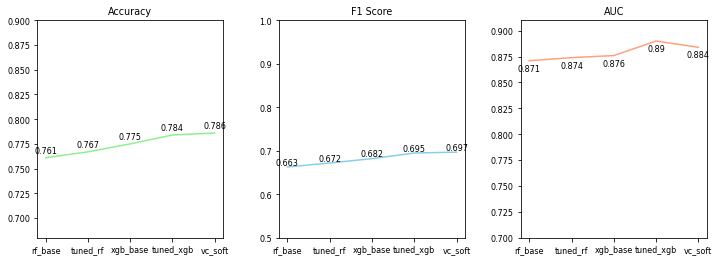

In [38]:
# Plot the performance of all five models
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
plt.subplots_adjust(wspace = 0.3)

# Extract x-ticks and model names
x_ticks = range(len(performance['Model']))
models = performance['Model'].to_list()

# Plot Balanced Accuracy
axs[0].plot(x_ticks, performance['Accuracy'], linestyle = '-', color = 'lightgreen')
axs[0].set_title('Accuracy')
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(models)
axs[0].set_ylim(0.68, 0.9)
y1 = performance['Accuracy'].to_list()
for i, y in enumerate(y1):
    axs[0].text(i, y+0.005, f'{y}', ha = 'center')

# Plot F1 Score
axs[1].plot(x_ticks, performance['F1 Score'], linestyle = '-', color = 'skyblue')
axs[1].set_title('F1 Score')
axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(models)
axs[1].set_ylim(0.5,1.0)
y2 = performance['F1 Score'].to_list()
for i, y in enumerate(y2):
    axs[1].text(i, y+0.005, f'{y}', ha = 'center')

# Plot AUC Score
axs[2].plot(x_ticks, performance['AUC'], linestyle = '-', color = 'lightsalmon')
axs[2].set_title('AUC')
axs[2].set_xticks(x_ticks)
axs[2].set_xticklabels(models)
axs[2].set_ylim(0.70, 0.91)
y3 = performance['AUC'].to_list()
for i, y in enumerate(y3):
    axs[2].text(i, y-0.01, f'{y}', ha = 'center')

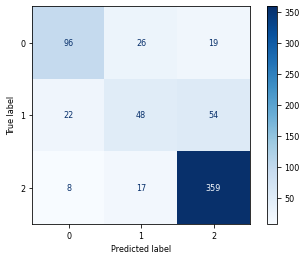

In [39]:
cm = confusion_matrix(test_labels, xgb_base.predict(test_features), labels = xgb_base.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_base.classes_)
disp.plot(cmap = 'Blues')
plt.show()

In [56]:
!pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


SHAP values shape: (649, 23, 3)


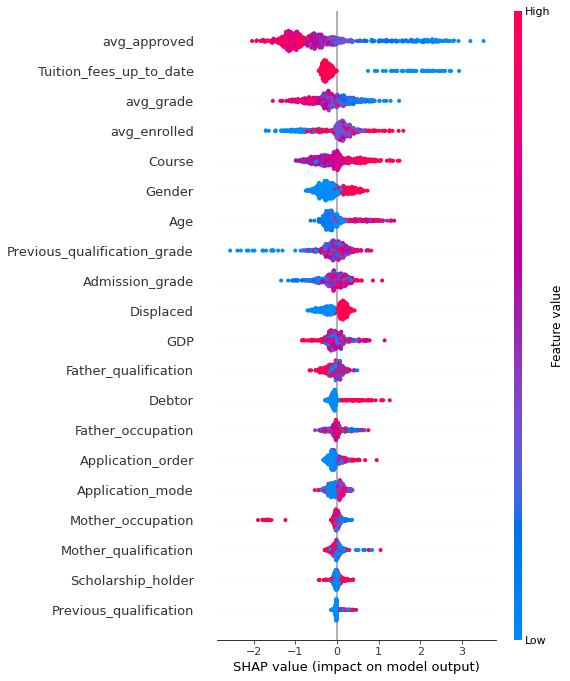

In [40]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(xgb_base)

# Calculate SHAP values for the test set
shap_values = explainer(test_features)

# Print SHAP values shape
print("SHAP values shape:", shap_values.values.shape)

# Summary plot (using the SHAP values for the first output)
shap.summary_plot(shap_values.values[..., 0], test_features, feature_names=test_features.columns)

# SHAP force plot for a specific instance and specific output
shap.initjs()  # For Jupyter Notebooks

# Visualize SHAP values for the first instance and the first output
instance_index = 0  # Change this index as needed
output_index = 0  # Select which output to visualize (0, 1, or 2)
shap.plots.force(explainer.expected_value[output_index],
                 shap_values.values[instance_index, :, output_index],
                 test_features.iloc[instance_index, :],
                 feature_names=test_features.columns)


## Model training - For 2 class : Graduate and Enrolled

In [41]:
# Remove rows of class-1 (enrolled) from training and test set
train_bi = train.drop(train[train['Target_encoded']==1].index)
test_bi = test.drop(test[test['Target_encoded']==1].index)

# Set the target label as 1 - 'Dropout', 0 - 'Graduate'
train_bi['Target_encoded'] = train_bi['Target_encoded'].replace([0, 2], [1, 0])
test_bi['Target_encoded'] = test_bi['Target_encoded'].replace([0, 2], [1, 0])

# Extract features and labels
train_bi_X = train_bi.drop('Target_encoded', axis = 1)
train_bi_y = train_bi['Target_encoded']
test_bi_X = test_bi.drop('Target_encoded', axis = 1)
test_bi_y = test_bi['Target_encoded']

In [42]:
# Train Random Forst on the training set
rf_bi = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf_bi.fit(train_bi_X, train_bi_y)

y_pred = rf_bi.predict(test_bi_X)
y_prob = rf_bi.predict_proba(test_bi_X)

rf_bi_accuracy = round(accuracy_score(test_bi_y, y_pred), 3)
rf_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
rf_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('Random Forest Baseline Performance:')
print('Accuracy:', rf_bi_accuracy)
print('F1 Score:', rf_bi_f1score)
print('AUC score:', rf_bi_auc)

Random Forest Baseline Performance:
Accuracy: 0.926
F1 Score: 0.847
AUC score: 0.944


In [51]:
# Tune hyperparameter of Random Forest
parm = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
    'max_samples': [0.5, 0.75, 1]
}

# Search for best hyperparameters combination
rsv_rf_bi = RandomizedSearchCV( estimator = RandomForestClassifier(class_weight = 'balanced',
                                                                   random_state = 42),
                                param_distributions = parm, scoring = 'balanced_accuracy',
                                n_iter = 30, n_jobs = -1,  random_state = 0)

rsv_rf_bi.fit(train_bi_X, train_bi_y)

# Get the best estimator
tuned_rf_bi = rsv_rf_bi.best_estimator_

# Check the model performance
y_pred = tuned_rf_bi.predict(test_bi_X)
y_prob = tuned_rf_bi.predict_proba(test_bi_X)

tuned_rf_bi_accuracy = round(accuracy_score(test_bi_y, y_pred), 3)
tuned_rf_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
tuned_rf_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('tuned_rf_bi Performance:')
print('Accuracy:', tuned_rf_bi_accuracy)
print('F1 Score:', tuned_rf_bi_f1score)
print('AUC score:', tuned_rf_bi_auc)

tuned_rf_bi Performance:
Accuracy: 0.926
F1 Score: 0.856
AUC score: 0.947


In [44]:
# Train XGBClassifier
neg_num = sum(train_bi_y == 0)
pos_num = sum(train_bi_y == 1)
weight = neg_num / pos_num

xgb_bi = XGBClassifier(enable_categorical = True, scale_pos_weight = weight,
                       importance_type = 'gain', random_state = 42)
xgb_bi.fit(train_bi_X, train_bi_y)

y_pred = xgb_bi.predict(test_bi_X)
y_prob = xgb_bi.predict_proba(test_bi_X)

xgb_bi_accuracy = round(accuracy_score(test_bi_y, y_pred), 3)
xgb_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
xgb_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('xgb_bi performance:')
print('Accuracy:', xgb_bi_accuracy)
print('F1 score:', xgb_bi_f1score)
print('AUC score:', xgb_bi_auc)

xgb_bi performance:
Accuracy: 0.935
F1 score: 0.875
AUC score: 0.958


In [48]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

# Optional visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate scale_pos_weight
weight = len(train_bi_y[train_bi_y == 0]) / len(train_bi_y[train_bi_y == 1])

# Define hyperparameter grid
param = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.5, 0.8]
}

# Encode categorical columns using OrdinalEncoder with unknown handling
train_X = train_bi_X.copy()
test_X = test_bi_X.copy()
cat_cols = train_X.select_dtypes(include=['category']).columns

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_X[cat_cols] = encoder.fit_transform(train_X[cat_cols])
test_X[cat_cols] = encoder.transform(test_X[cat_cols])

# Initialize RandomizedSearchCV with XGBClassifier
rsv_xgb_bi = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        scale_pos_weight=weight,
        random_state=42
    ),
    param_distributions=param,
    scoring='balanced_accuracy',
    n_iter=50,
    n_jobs=-1,
    random_state=6
)

# Fit the model
rsv_xgb_bi.fit(train_X, train_bi_y)

# Extract the best estimator
tuned_xgb_bi = rsv_xgb_bi.best_estimator_

# Make predictions
y_pred = tuned_xgb_bi.predict(test_X)
y_prob = tuned_xgb_bi.predict_proba(test_X)

# Evaluate performance
tuned_xgb_bi_accuracy = round(accuracy_score(test_bi_y, y_pred), 3)
tuned_xgb_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
tuned_xgb_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

# Print results
print('Tuned XGBoost (Binary) Performance:')
print('Accuracy:', tuned_xgb_bi_accuracy)
print('F1 Score:', tuned_xgb_bi_f1score)
print('AUC Score:', tuned_xgb_bi_auc)


[15:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Tuned XGBoost (Binary) Performance:
Accuracy: 0.933
F1 Score: 0.877
AUC Score: 0.958


In [49]:
# Tune the hyperparameters of XGBClassifier
param = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.5, 0.8]
}

rsv_xgb_bi = RandomizedSearchCV(estimator = XGBClassifier(enable_categorical = True,
                                                          scale_pos_weight = weight,
                                                          random_state = 42),
                                param_distributions = param, scoring = 'balanced_accuracy',
                                n_iter= 50, n_jobs = -1, random_state = 6)

rsv_xgb_bi.fit(train_bi_X, train_bi_y)

# Extract best estimator
tuned_xgb_bi = rsv_xgb_bi.best_estimator_

# Check 'tuned_xgb_bi' performance
y_pred = tuned_xgb_bi.predict(test_bi_X)
y_prob = tuned_xgb_bi.predict_proba(test_bi_X)

tuned_xgb_bi_accuracy = round(accuracy_score(test_bi_y, y_pred), 3)
tuned_xgb_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
tuned_xgb_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('tuned_xgb_bi performance:')
print('Accuracy:', tuned_xgb_bi_accuracy)
print('F1 score:', tuned_xgb_bi_f1score)
print('AUC score:', tuned_xgb_bi_auc)

tuned_xgb_bi performance:
Accuracy: 0.926
F1 score: 0.86
AUC score: 0.954


In [50]:
# Combine best models into VotingClassifer
vc_soft_bi = VotingClassifier(estimators = [('rf', tuned_rf_bi), ('xgb', xgb_bi)],
                              voting = 'soft')
vc_soft_bi.fit(train_bi_X, train_bi_y)

y_pred = vc_soft_bi.predict(test_bi_X)
y_prob = vc_soft_bi.predict_proba(test_bi_X)

vc_soft_bi_accuracy = round(accuracy_score(test_bi_y, y_pred), 3)
vc_soft_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
vc_soft_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('vc_soft_bi performance:')
print('Accuracy:', vc_soft_bi_accuracy)
print('F1 score:', vc_soft_bi_f1score)
print('AUC score:', vc_soft_bi_auc)

vc_soft_bi performance:
Accuracy: 0.93
F1 score: 0.863
AUC score: 0.952


In [52]:
# Compare model performance
pd.DataFrame({
            'Model': ['rf_bi', 'tuned_rf_bi', 'xgb_bi', 'tuned_xgb_bi', 'vc_soft_bi'],
            'Accuracy': [rf_bi_accuracy, tuned_rf_bi_accuracy, xgb_bi_accuracy,
                                  tuned_xgb_bi_accuracy, vc_soft_bi_accuracy],
            'F1 Score': [rf_bi_f1score, tuned_rf_bi_f1score, xgb_bi_f1score,
                         tuned_xgb_bi_f1score, vc_soft_bi_f1score],
            'AUC': [rf_bi_auc, tuned_rf_bi_auc, xgb_bi_auc, tuned_xgb_bi_auc, vc_soft_bi_auc]
            })

,Model,Accuracy,F1 Score,AUC
0,rf_bi,0.926,0.847,0.944
1,tuned_rf_bi,0.926,0.856,0.947
2,xgb_bi,0.935,0.875,0.958
3,tuned_xgb_bi,0.926,0.860,0.954
4,vc_soft_bi,0.930,0.863,0.952


In [53]:
# Compare model performance
performance = pd.DataFrame({
            'Model': ['rf_bi', 'tuned_rf_bi', 'xgb_bi', 'tuned_xgb_bi', 'vc_soft_bi'],
            'Accuracy': [rf_bi_accuracy, tuned_rf_bi_accuracy, xgb_bi_accuracy,
                                  tuned_xgb_bi_accuracy, vc_soft_bi_accuracy],
            'F1 Score': [rf_bi_f1score, tuned_rf_bi_f1score, xgb_bi_f1score,
                         tuned_xgb_bi_f1score, vc_soft_bi_f1score],
            'AUC': [rf_bi_auc, tuned_rf_bi_auc, xgb_bi_auc, tuned_xgb_bi_auc, vc_soft_bi_auc]
            })

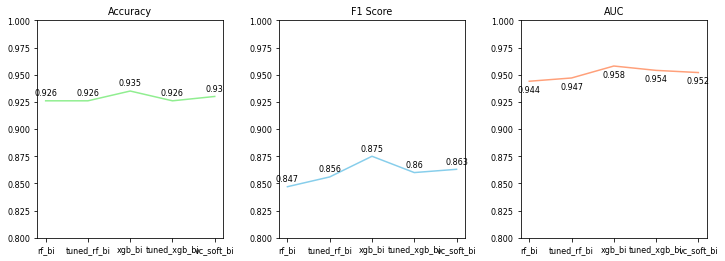

In [54]:
# Plot the performance of all five models
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
plt.subplots_adjust(wspace = 0.3)

# Extract x-ticks and model names
x_ticks = range(len(performance['Model']))
models = performance['Model'].to_list()

# Plot Balanced Accuracy
axs[0].plot(x_ticks, performance['Accuracy'], linestyle = '-', color = 'lightgreen')
axs[0].set_title('Accuracy')
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(models)
axs[0].set_ylim(0.8, 1.0)
y1 = performance['Accuracy'].to_list()
for i, y in enumerate(y1):
    axs[0].text(i, y+0.005, f'{y}', ha = 'center')

# Plot F1 Score
axs[1].plot(x_ticks, performance['F1 Score'], linestyle = '-', color = 'skyblue')
axs[1].set_title('F1 Score')
axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(models)
axs[1].set_ylim(0.8,1.0)
y2 = performance['F1 Score'].to_list()
for i, y in enumerate(y2):
    axs[1].text(i, y+0.005, f'{y}', ha = 'center')

# Plot AUC Score
axs[2].plot(x_ticks, performance['AUC'], linestyle = '-', color = 'lightsalmon')
axs[2].set_title('AUC')
axs[2].set_xticks(x_ticks)
axs[2].set_xticklabels(models)
axs[2].set_ylim(0.8, 1.0)
y3 = performance['AUC'].to_list()
for i, y in enumerate(y3):
    axs[2].text(i, y-0.01, f'{y}', ha = 'center')

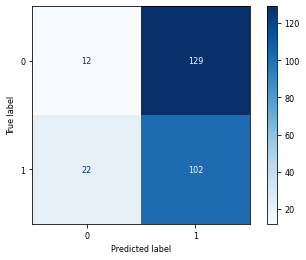

In [55]:
cm = confusion_matrix(test_labels, xgb_bi.predict(test_features), labels = xgb_bi.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_bi.classes_)
disp.plot(cmap = 'Blues')
plt.show()

SHAP values shape: (525, 23)


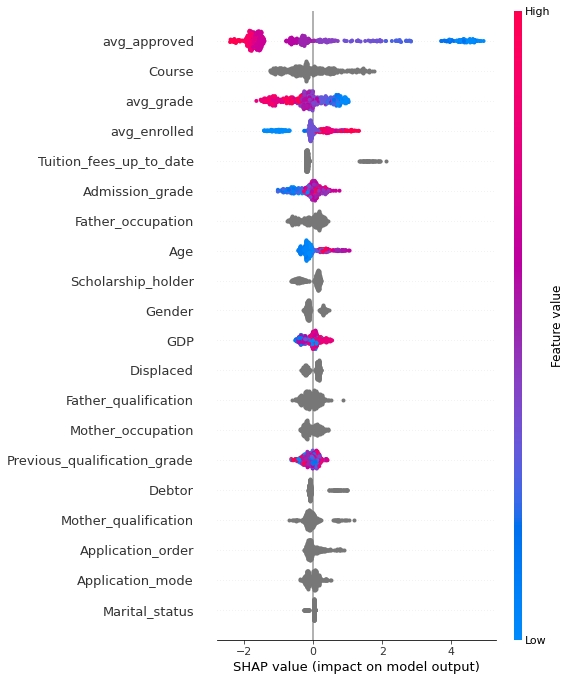

In [56]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(tuned_xgb_bi)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(test_bi_X)

# Print SHAP values shape
print("SHAP values shape:", shap_values.shape)

# Summary plot
shap.summary_plot(shap_values, test_bi_X, feature_names=test_bi_X.columns)

# SHAP force plot for a specific instance
shap.initjs()  # For Jupyter Notebooks

# Visualize SHAP values for the first instance
instance_index = 0  # Change this index as needed
shap.force_plot(explainer.expected_value, shap_values[instance_index], test_bi_X.iloc[instance_index, :],
                 feature_names=test_bi_X.columns)
